# Spectrogram based sEMG classification model

### Includes

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Conv2D, BatchNormalization, MaxPooling2D 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import TensorBoard
from time import time
from random import choice, shuffle
from scipy.signal import spectrogram
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
%matplotlib inline
%load_ext tensorboard

### Setting workspace

In [3]:
os.chdir('..')
ROOT = os.getcwd()
DIR_PATH = os.path.join(ROOT, 'datasets/myo_data')

### Constants

In [4]:
LABELS = ['Flexion', 'Extension', 'Fist', 'Neutral']
NB_LABELS = len(LABELS)
NB_CHANNELS = 8

### Random Label

In [5]:
label = choice(LABELS)
sample_file = choice(os.listdir(os.path.join(DIR_PATH, label)))
sample_path = os.path.join(DIR_PATH, label, sample_file)
print(f'Sample of {label} label')
sample_df = pd.read_csv(sample_path)
sample_df.head()

Sample of Extension label


,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8
0,-3,-7,-29,-96,-41,-6,-4,-1
1,3,8,11,9,8,14,6,2
2,-5,-8,-7,-9,-25,-11,-6,-3
3,2,5,12,48,24,1,-2,1
4,3,3,5,9,-8,4,5,3


### Spectrogram parameters

In [6]:
nperseg = 10 #increasing nperseg increases frequency resolution and decreases time res
noverlap = 8 #increasing time resolution requires increasing overlap
window = 'hann' #hann provides good time and frequency resolution properties

### Plotting spectrograms for a sample

Spectrogram shape: (6, 21)


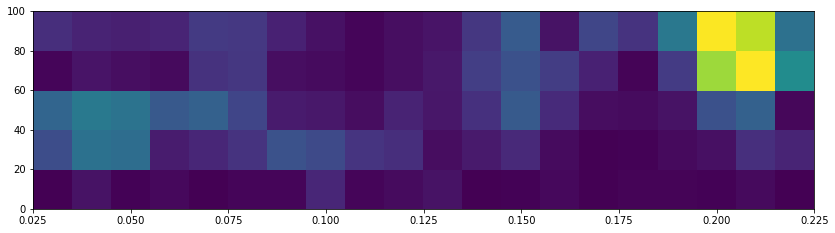

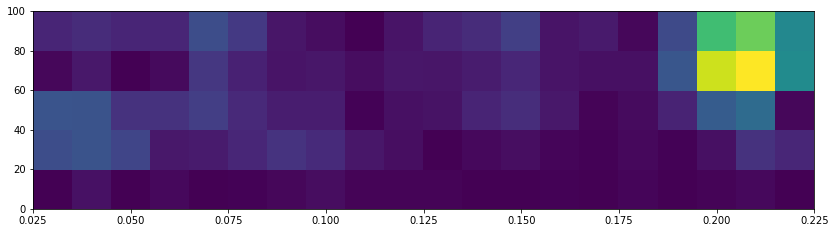

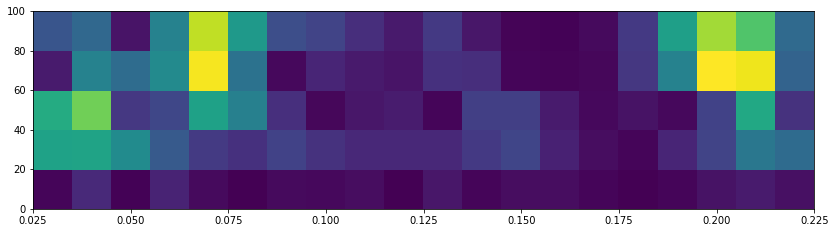

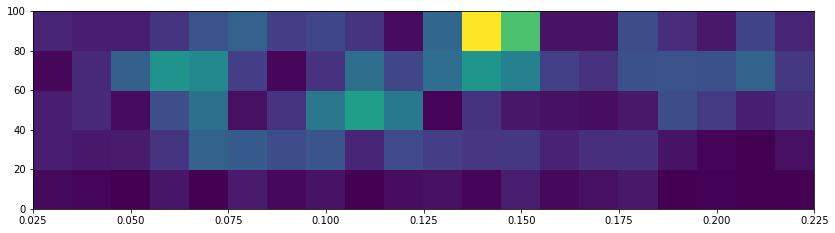

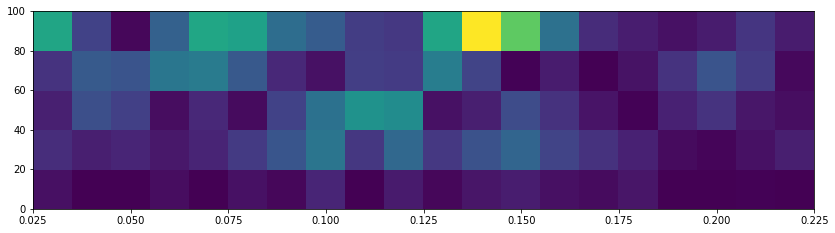

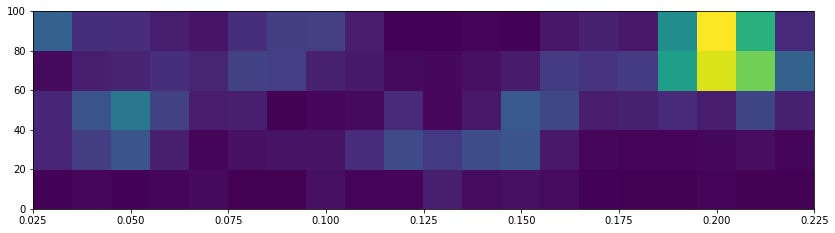

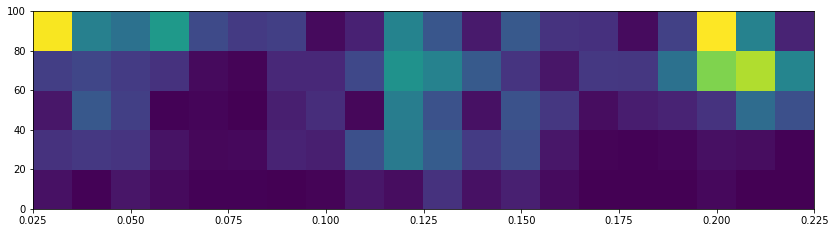

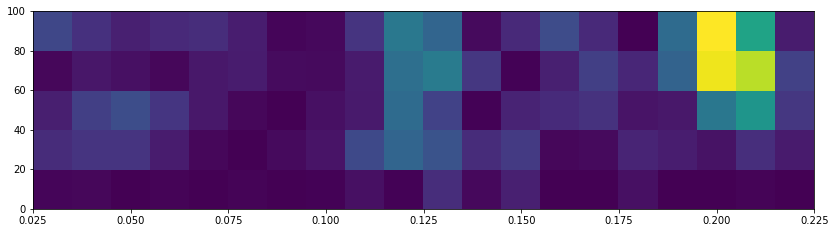

In [7]:
for col in sample_df.columns:
    frequencies, times, spec = spectrogram(x=sample_df[col], fs=200, nperseg=nperseg, noverlap=noverlap, window=window)
    fig = plt.figure(figsize=(14, 8))
    fig.add_subplot(211)
    plt.pcolormesh(times, frequencies, spec)
    plt.show

spec_shape = spec.shape
print('Spectrogram shape:', spec_shape)

### Building dataset

In [8]:
n_samples = np.sum([len(os.listdir(os.path.join(DIR_PATH, label))) for label in LABELS])

In [9]:
dataset = np.zeros(shape = (n_samples, *spec_shape, 8))
n_samp = 0
img_shape = (*spec_shape, 8)
img = np.zeros(img_shape)
for label in LABELS:
    files = os.listdir(os.path.join(DIR_PATH, label))
    for file in files:
        sample_df = pd.read_csv(os.path.join(DIR_PATH, label, file))
        for i, ch in enumerate(sample_df.columns):
            frequencies, times, spec = spectrogram(x=sample_df[ch],
                                                   fs=200,
                                                   nperseg=nperseg,
                                                   noverlap=noverlap,
                                                   window=window)
            img[:,:,i] = spec 
        dataset[n_samp] = img
        n_samp += 1

In [10]:
labels = []
for label in LABELS:
    labels.append(len(os.listdir(os.path.join(DIR_PATH, label))))
dataset_labels=[]
for i, label in enumerate(labels):
    y = np.repeat(i, label)
    dataset_labels.append(y)
dataset_labels = np.concatenate(dataset_labels)
dataset_labels = to_categorical(dataset_labels)

In [11]:
indexes = list(range(n_samples))
shuffle(indexes)
indexes = np.array(indexes)

In [12]:
dataset = dataset[indexes]
dataset_labels = dataset_labels[indexes]
split = len(dataset)//5
x_train = dataset[:n_samples-split]
x_test = dataset[n_samples-split:]
y_train = dataset_labels[:n_samples-split]
y_test = dataset_labels[n_samples-split:]

In [13]:
len(dataset)//5

520

In [14]:
print(f'Dataset shape: {dataset.shape}')
print(f'Labels shape: {dataset_labels.shape}')

Dataset shape: (2601, 6, 21, 8)
Labels shape: (2601, 4)


In [15]:
def build_model(input_shape, nclass):
    inputlayer = Input(shape=input_shape)
    
    BatchNorm = BatchNormalization()(inputlayer)
    model = Conv2D(32, kernel_size=2, padding='same', activation='relu')(BatchNorm)
    model = Conv2D(32, kernel_size=2, padding='same', activation='relu')(model)
    model = MaxPooling2D(pool_size=(2, 2))(model)
    model = Dropout(rate=0.2)(model)
    model = Conv2D(64, kernel_size=3, padding='same', activation='relu')(model)
    model = Conv2D(64, kernel_size=3, padding='same', activation='relu')(model)
    model = MaxPooling2D(pool_size=(2, 2))(model)
    model = Dropout(rate=0.2)(model)
    model = Conv2D(128, kernel_size=3, padding='same', activation='relu')(model)
    model = Conv2D(128, kernel_size=3, padding='same', activation='relu')(model)
    model = MaxPooling2D(pool_size=(1, 1))(model)
    model = Flatten()(model) 

    dense = BatchNormalization()(Dense(128, activation='relu')(model))
    dense = BatchNormalization()(Dense(128, activation='relu')(dense))
    dense = Dense(nclass, activation='softmax')(dense)

    model = Model(inputs=inputlayer, outputs=dense)
    
    return model

In [16]:
model = build_model(dataset.shape[1:], 4)

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6, 21, 8)]        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 6, 21, 8)          32        
_________________________________________________________________
conv2d (Conv2D)              (None, 6, 21, 32)         1056      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 21, 32)         4128      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 10, 32)         0         
_________________________________________________________________
dropout (Dropout)            (None, 3, 10, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 10, 64)         18496 

### Optimizer

In [18]:
optimizer = Adam(lr = 0.0001,
                 beta_1 = 0.9,
                 beta_2 = 0.999,
                 epsilon = 1e-08)

### Callbacks 

In [19]:
callbacks = [TensorBoard(log_dir=os.path.join(ROOT, 'logs', f'spec'))]

### Compiling and training model

In [20]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train,
                   y_train,
                   batch_size=50,
                   epochs=30,
                   validation_split=0.25,
                   callbacks=callbacks)

Train on 1560 samples, validate on 521 samples
Epoch 1/30
1560/1560 [==============================] - 2s 1ms/sample - loss: 1.1415 - accuracy: 0.5224 - val_loss: 1.3456 - val_accuracy: 0.6084
Epoch 2/30
1560/1560 [==============================] - 1s 581us/sample - loss: 0.6152 - accuracy: 0.7577 - val_loss: 1.3151 - val_accuracy: 0.6891
Epoch 3/30
1560/1560 [==============================] - 1s 819us/sample - loss: 0.3626 - accuracy: 0.8756 - val_loss: 1.2683 - val_accuracy: 0.7390
Epoch 4/30
1560/1560 [==============================] - 1s 712us/sample - loss: 0.2695 - accuracy: 0.9103 - val_loss: 1.2171 - val_accuracy: 0.7965
Epoch 5/30
1560/1560 [==============================] - 1s 639us/sample - loss: 0.2312 - accuracy: 0.9295 - val_loss: 1.1597 - val_accuracy: 0.8772
Epoch 6/30
1560/1560 [==============================] - 1s 531us/sample - loss: 0.1958 - accuracy: 0.9410 - val_loss: 1.0883 - val_accuracy: 0.9290
Epoch 7/30
1560/1560 [==============================] - 1s 497us/sa

### Tensorboard

In [21]:
%tensorboard --logdir=./logs/spec

### Cross validation

In [22]:
test = model.evaluate(x_test, y_test)

520/520 [==============================] - 0s 219us/sample - loss: 0.0342 - accuracy: 0.9942


### Saving model

In [23]:
model.save('models/spec_model.h5')